In [ ]:
!git clone https://github.com/pumpikano/tf-dann

In [ ]:
cd 'tf-dann/'
%tensorflow_version 1.15

In [253]:

from functools import partial
def compute_pairwise_distances(x, y):
  """Computes the squared pairwise Euclidean distances between x and y.
  Args:
    x: a tensor of shape [num_x_samples, num_features]
    y: a tensor of shape [num_y_samples, num_features]
  Returns:
    a distance matrix of dimensions [num_x_samples, num_y_samples].
  Raises:
    ValueError: if the inputs do no matched the specified dimensions.
  """

  if not len(x.get_shape()) == len(y.get_shape()) == 2:
    raise ValueError('Both inputs should be matrices.')

  if x.get_shape().as_list()[1] != y.get_shape().as_list()[1]:
    raise ValueError('The number of features should be the same.')

  norm = lambda x: tf.reduce_sum(tf.square(x), 1)

  # By making the `inner' dimensions of the two matrices equal to 1 using
  # broadcasting then we are essentially substracting every pair of rows
  # of x and y.
  # x will be num_samples x num_features x 1,
  # and y will be 1 x num_features x num_samples (after broadcasting).
  # After the substraction we will get a
  # num_x_samples x num_features x num_y_samples matrix.
  # The resulting dist will be of shape num_y_samples x num_x_samples.
  # and thus we need to transpose it again.
  return tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))
  
def gaussian_kernel_matrix(x, y, sigmas):
  r"""Computes a Guassian Radial Basis Kernel between the samples of x and y.
  We create a sum of multiple gaussian kernels each having a width sigma_i.
  Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
  Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
  """
  beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))

  dist = compute_pairwise_distances(x, y)

  s = tf.matmul(beta, tf.reshape(dist, (1, -1)))
  return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))

def normalize(x, mean = None, std = None):

    x_reshaped = tf.reshape(x,[-1,3])
  
        # mean of each column/sensor
    x_reshaped = (x_reshaped-mean)/std
    # reshape back to original shape
    return tf.reshape(x_reshaped,[-1,128,3])


def fixprob(att):
    att = att + 1e-9
    _sum = tf.reduce_sum(att, reduction_indices=1, keep_dims=True)
    att = att / _sum
    att = tf.clip_by_value(att, 1e-9, 1.0, name=None)
    return att

def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix):
  r"""Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
  Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
  the distributions of x and y. Here we use the kernel two sample estimate
  using the empirical mean of the two distributions.
  MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
  where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
  Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
  Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
  """
  with tf.name_scope('MaximumMeanDiscrepancy'):
    # \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) }
    cost = tf.reduce_mean(kernel(x, x))
    cost += tf.reduce_mean(kernel(y, y))
    cost -= 2 * tf.reduce_mean(kernel(x, y))

    # We do not allow the loss to become negative.
    cost = tf.where(cost > 0, cost, 0, name='value')
  return cost


def mmd_loss(source_samples, target_samples, weight, scope=None):
  """Adds a similarity loss term, the MMD between two representations.
  This Maximum Mean Discrepancy (MMD) loss is calculated with a number of
  different Gaussian kernels.
  Args:
    source_samples: a tensor of shape [num_samples, num_features].
    target_samples: a tensor of shape [num_samples, num_features].
    weight: the weight of the MMD loss.
    scope: optional name scope for summary tags.
  Returns:
    a scalar tensor representing the MMD loss value.
  """
  sigmas = [
      1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
      1e3, 1e4, 1e5, 1e6
  ]
  gaussian_kernel = partial(
      gaussian_kernel_matrix, sigmas=tf.constant(sigmas))

  loss_value = maximum_mean_discrepancy(
      source_samples, target_samples, kernel=gaussian_kernel)
  loss_value = tf.maximum(1e-4, loss_value) * weight
  return loss_value


In [254]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.datasets import make_moons, make_blobs
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from flip_gradient import flip_gradient
from sklearn.model_selection import train_test_split
from utils import *



# #%% case1 + overlap

# Xs, ys = make_blobs(1000, centers=[[0, 1], [-0.2, 2]], cluster_std=[0.35,0.3])
# Xt, yt = make_blobs(1000, centers=[[0.7, -0.2], [0.6, -1.3]], cluster_std=[0.3,0.4])

# plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
# plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
# plt.title('Source domain and target domain blobs data',fontsize=14,fontweight='bold')
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)


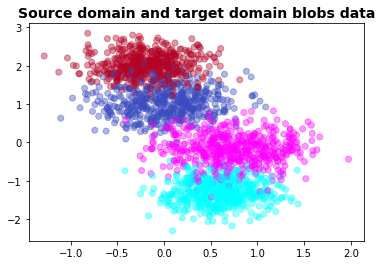

In [255]:

#%% case5 

Xs, ys = make_blobs(1000, centers=[[0, 1], [-0.2, 2]], cluster_std=[0.35,0.3])
Xt, yt = make_blobs(1000, centers=[[0.6, -1.3], [0.7, -0.2]], cluster_std=[0.3,0.4])

plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
plt.title('Source domain and target domain blobs data',fontsize=14,fontweight='bold')
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)


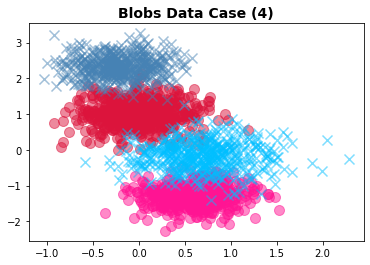

In [262]:

# manual_seed=1234
# seed(manual_seed)

# seed numpy 

#tensorflow global seed


def generate_cases(case,color_s,color_t,datasize=500,save=False):
    ''' 
    This function generate different toy data with cases of overlaps 
    
    inputs:
        case: int
        datasize: int
    
    output:
         train and test data 
    '''
    path='toy_example_results/DASH/'
    if case==0:
# case 0

        Xs, ys = make_blobs(datasize, centers=[[0, 0], [0, 2]], cluster_std=[0.3,0.35])
        Xt, yt = make_blobs(datasize, centers=[[2, -2], [2, 0.2]], cluster_std=[0.35,0.4])

        

    #case1: inner overlap
    elif case==1:
        Xs, ys = make_blobs(datasize, centers=[[0, 0], [0, 1.2]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[2.2, -1.2], [2.2, 0]], cluster_std=[0.3,0.4])

        


 #%% case2: cross overlap
    elif case==2:

        Xs, ys = make_blobs(datasize, centers=[[0, 0], [-.5, 2]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[1.5, -2], [1, 0]], cluster_std=[0.3,0.4])

        

# #%% case3: cross domain and within domain overlap
    elif case==3:
        Xs, ys = make_blobs(datasize, centers=[[0, 0], [-0.4, 1]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[1.5, -1], [1, 0]], cluster_std=[0.3,0.4])
        

#case 4 cross domain and within domain overlap
    elif case==4:
        Xs, ys = make_blobs(datasize, centers=[[0, 1], [-0.2, 2.3]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[0.6, -1.3], [0.7, -0.2]], cluster_std=[0.3,0.4])

        
#case 5 within domain overlap
    elif case==5:
        Xs, ys = make_blobs(datasize, centers=[[0, 1.3], [-0.2, 2.5]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[0.6, -1.5], [0.8, -0.5]], cluster_std=[0.3,0.4])


# #%% case6: flipped
    elif case==6:

        Xs, ys = make_blobs(datasize, centers=[[0, 0.5], [-0.2, 2]], cluster_std=[0.35,0.3])
        Xt, yt = make_blobs(datasize, centers=[[1.5, 2], [1.7, 0.5]], cluster_std=[0.3,0.4])

    plt.scatter(Xs[ys == 0, 0], Xs[ys == 0, 1],color=color_s[0], marker='o',alpha=0.5,s=100)
    plt.scatter(Xs[ys == 1, 0], Xs[ys == 1, 1],color=color_s[1], marker='x',alpha=0.5,s=100)

    plt.scatter(Xt[yt == 0, 0], Xt[yt == 0, 1],color=color_t[0], marker='o',alpha=0.5,s=100)
    plt.scatter(Xt[yt == 1, 0], Xt[yt == 1, 1],color=color_t[1], marker='x',alpha=0.5,s=100)

    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)
    plt.title('Blobs Data Case (%d)'%(case),fontsize=14,fontweight='bold')
    if save==True:
        plt.savefig(path+'case_%d.png'%(case),dpi=400,bbox_inches='tight') 
    plt.show()
    return X_train_s, X_test_s, y_train_s, y_test_s,X_train_t, X_test_t, y_train_t, y_test_t

# #%%case3 +overlap
# Xs, ys = make_blobs(1000, centers=[[0.6, -1.3], [-0.2, 2]], cluster_std=[0.35,0.3])
# Xt, yt = make_blobs(1000, centers=[[0, 1], [0.7, -0.2]], cluster_std=[0.3,0.4])

# plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
# plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)


# #%%case3 +np overlap
# Xs, ys = make_blobs(1000, centers=[[0.6, -2.5], [-0.2, 3]], cluster_std=[0.35,0.3])
# Xt, yt = make_blobs(1000, centers=[[0, 1.2], [0.7, -0.3]], cluster_std=[0.3,0.4])

# plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
# plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)


# #%%case5 

# Xs, ys = make_blobs(1000, centers=[[0, 1], [-0.2, 2]], cluster_std=[0.35,0.3])
# Xt, yt = make_blobs(1000, centers=[[0.6, -1.3], [0.7, -0.2]], cluster_std=[0.3,0.4])


# plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
# plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)

# #%%case6

# Xs, ys = make_blobs(1000, centers=[[-0.2, -.2], [0, 1.5]], cluster_std=[0.35,0.3])
# Xt, yt = make_blobs(1000, centers=[ [1.8, 2],[1.1, 0.8]], cluster_std=[0.3,0.4])

# plt.scatter(Xs[:,0], Xs[:,1], c=ys, cmap='coolwarm', alpha=0.4)
# plt.scatter(Xt[:,0], Xt[:,1], c=yt, cmap='cool', alpha=0.4)
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.3, random_state=42)
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.3, random_state=42)
color_s=['crimson','steelblue']
color_t=['deeppink','deepskyblue']
X_train_s, X_test_s, y_train_s, y_test_s,X_train_t, X_test_t, y_train_t, y_test_t=generate_cases(4,color_s,color_t,1000,False)


In [233]:
class HPS:
    """Hard parameter sharing domain adaptation model."""
    def __init__(self,loss,activation):
        self.loss=loss
        self.build_model(activation)
        
    def build_model(self,activation=tf.nn.relu):
        self.X_s = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_s') # Input data
        self.X_t = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_t')
        self.Y_s = tf.compat.v1.placeholder(tf.int32, [None], name='Y_s')  # Class index
        self.Y_t = tf.compat.v1.placeholder(tf.int32, [None], name='Y_t')
        self.D_ind = tf.compat.v1.placeholder(tf.int32, [None], name='D_ind')  # Domain index
        self.train = tf.compat.v1.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
        self.l = tf.compat.v1.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler

        y_s = tf.one_hot(self.Y_s, 2)
        y_t = tf.one_hot(self.Y_t, 2)

        D = tf.one_hot(self.D_ind, 2)

        # Feature extractor
        with tf.compat.v1.variable_scope('source_feature_extractor'):
            layer1=fc_layer(self.X_s,2,8, name="source_fc1")
            layer1=activation(layer1)
            F_s=fc_layer(layer1,8,16,name="source_fc2")
            self.feature=activation(F_s)
           
            
        # MLP for activity prediction
        with tf.variable_scope('label_predictor'):
            
            # Switches to route target examples (second half of batch) differently
            # depending on train or test mode.
            all_features = lambda: self.feature
            source_features = lambda: tf.slice(self.feature, [0, 0], [self.batch_size // 2,-1])
            classify_feats = tf.cond(self.train, source_features, all_features)
           
            all_labels = lambda: self.y
            source_labels = lambda: tf.slice(self.y, [0, 0], [self.batch_size // 2, -1])
            self.classify_labels = tf.cond(self.train, source_labels, all_labels)
            dim = classify_feats.get_shape().as_list()[1]   
            
            p_logit = fc_layer(classify_feats, dim,2,name='fc3')(2)(self.classify_labels)
            p = tf.nn.softmax(logits)
            p_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.classify_labels))
          
            # domain adaptation objective
        if self.da_loss == 'MMD':
            with tf.variable_scope('MMD'):
                feat_s = tf.slice(self.feature, [0, 0], [self.batch_size // 2,-1])
                feat_t = tf.slice(self.feature, [self.batch_size // 2, 0], [-1,-1])
                x = fixprob(feat_s)
                y = fixprob(feat_t)
                self.adversarial_loss = mmd_loss(x, y, self.l)
                
        elif self.da_loss == 'DC':
             with tf.variable_scope('domain_predictor'):
                
                # Flip the gradient when backpropagating through this operation
                feat = flip_gradient( self.feature, self.l)
                
                layer3 = layers.Dense(128,activation=tf.nn.relu)(feat)
                layer3 = layers.Dense(64,activation=tf.nn.relu)(layer3)
                
                d_logits = layers.Dense(2)(layer3)
                
                self.domain_pred = tf.nn.softmax(d_logits)
                d_pred = tf.equal(tf.argmax(self.domain, 1), tf.argmax(self.domain_pred, 1))
                self.domain_acc = tf.reduce_mean(tf.cast(d_pred, tf.float32))
                self.adversarial_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=d_logits, labels=self.domain))
            
        # Optimization

        self.pred_loss = tf.reduce_mean(p_loss, name='pred_loss')
        
        self.total_loss = self.pred_loss+self.adversarial_loss

        self.pred_train_op = tf.train.AdamOptimizer().minimize(self.pred_loss, name='pred_train_op')
        self.domain_train_op = tf.train.AdamOptimizer().minimize(self.adversarial_loss, name='domain_train_op')
        self.total_train_op = tf.train.AdamOptimizer().minimize(self.total_loss, name='dann_train_op')

        # Evaluation
        self.p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.classify_labels, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')

In [234]:
#%%

def fc_layer(input, size_in, size_out, name="fc",init_val=None,tr=True):
  
  with tf.name_scope(name):
   if init_val==None:
      
        w = tf.get_variable(name="W%s"%(name),initializer=tf.truncated_normal([size_in, size_out], stddev=0.1),trainable=tr)
        b = tf.get_variable(initializer=tf.constant_initializer(0.1),name="B%s"%(name),shape=[size_out],trainable=tr)
        
   else:
        w = tf.get_variable(name="W%s"%(name),shape=[size_in, size_out],initializer=tf.constant_initializer(init_val[0]),trainable=tr)
        b = tf.get_variable(initializer=tf.constant_initializer(init_val[1]),name="B%s"%(name),shape=[size_out],trainable=tr)
   act = tf.matmul(input, w) + b

   return act


batch_size = 16
class HPS:
    """Hard parameter sharing domain adaptation model."""
    def __init__(self,loss,activation):
        self.loss=loss
        self.build_model(activation)
        
    def build_model(self,activation=tf.nn.relu):
        self.X_s = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_s') # Input data
        self.X_t = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_t')
        self.Y_s = tf.compat.v1.placeholder(tf.int32, [None], name='Y_s')  # Class index
        self.Y_t = tf.compat.v1.placeholder(tf.int32, [None], name='Y_t')
        self.D_ind = tf.compat.v1.placeholder(tf.int32, [None], name='D_ind')  # Domain index
        self.train = tf.compat.v1.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
        self.l = tf.compat.v1.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler

        y_s = tf.one_hot(self.Y_s, 2)
        y_t = tf.one_hot(self.Y_t, 2)

        D = tf.one_hot(self.D_ind, 2)

        # Feature extractor
        with tf.compat.v1.variable_scope('source_feature_extractor') as source:
            layer1=fc_layer(self.X_s,2,8, name="source_fc1")
            layer1=activation(layer1)
            F_s=fc_layer(layer1,8,16,name="source_fc2")
            self.F_s=activation(F_s)
        
        with tf.compat.v1.variable_scope(source, reuse=True):
            layer1_t=fc_layer(self.X_t,2,8, name="source_fc1")
            layer1_t=activation(layer1_t)
            F_t=fc_layer(layer1_t,8,16,name="source_fc2")
            self.F_t=activation(F_t)
        
        with tf.compat.v1.variable_scope('label_predictor'):
            # Label predictor - single layer
            target_features = lambda: self.F_t
            source_features = lambda: self.F_s
            classify_feats = tf.cond(self.train, source_features, target_features)

            target_labels = lambda:y_t
            source_labels = lambda:y_s
            self.classify_labels = tf.cond(self.train, source_labels, target_labels)
            dim=classify_feats.get_shape().as_list()[1]
          
            p_logit=fc_layer(classify_feats,dim,2,name='fc3')
            p = tf.nn.softmax(p_logit)
            p_loss = tf.nn.softmax_cross_entropy_with_logits(logits=p_logit, labels=self.classify_labels )
        

        domain_merge=layers.concatenate([self.F_s,self.F_t],name='merged_features',axis=0)
        self.feature=domain_merge

        if self.loss=='MMD':
            with tf.variable_scope('MMD'):
                s_prop = fixprob(self.F_s)
                t_prop = fixprob(self.F_t)
               
                self.adversarial_loss=tf.reduce_sum(mmd_loss(s_prop, t_prop,self.l))

        elif self.loss=='DC':

            with tf.variable_scope('domain_predictor'):
                feat = flip_gradient(self.feature,self.l)
        
                d=tf.compat.v1.layers.dense(feat,16,activation=activation)
                d=tf.compat.v1.layers.dense(d,8,activation=activation)
                d_logit=tf.compat.v1.layers.dense(d,2)
                d = tf.nn.softmax(d_logit)
                self.adversarial_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D))



        # Optimization

        self.pred_loss = tf.reduce_mean(p_loss, name='pred_loss')
        
        self.total_loss = self.pred_loss+0.5*self.adversarial_loss

        self.pred_train_op = tf.train.AdamOptimizer().minimize(self.pred_loss, name='pred_train_op')
        self.domain_train_op = tf.train.AdamOptimizer().minimize(self.adversarial_loss, name='domain_train_op')
        self.total_train_op = tf.train.AdamOptimizer().minimize(self.total_loss, name='dann_train_op')

        # Evaluation
        self.p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.classify_labels, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')

        





In [208]:
#%%
tf.reset_default_graph()
graph = tf.get_default_graph()

with graph.as_default():
    model = HPS('MMD',tf.nn.relu)


In [268]:


#%%  
        
def train_and_evaluate(opt=None, grad_scale=None, num_batches=6000, verbose=True):
    # Create batch builders
    
  S_batches = batch_generator([X_train_s, y_train_s], batch_size // 2)
  T_batches = batch_generator([X_train_t, y_train_t], batch_size // 2)

  
  domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                                  np.tile([0., 1.], [batch_size // 2, 1])])
  
  # Get output tensors and train op
  
  p_acc = model.p_acc
  
  if opt == None:
    print('Pretraining with no adaptation')
    train_loss = model.pred_loss
    train_op = model.pred_train_op
  elif opt == 'adapt':
    print('Adaptation with no %s'%(model.loss))
    train_loss = model.total_loss
    train_op = model.total_train_op
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  for i in range(num_batches):

    # If no grad_scale, use a schedule
    if grad_scale is None:
      p = float(i) / num_batches
      lp = 2. / (1. + np.exp(-10. * p)) - 1
    else:
      lp = grad_scale

    X0, y0 = next(S_batches)
    X1, y1 = next(T_batches)
    
    D_labels = np.hstack([np.zeros(batch_size // 2, dtype=np.int32),np.ones(batch_size // 2, dtype=np.int32)])
    _, loss, da, pa = sess.run([train_op, train_loss, model.adversarial_loss, p_acc],feed_dict={model.X_s: X0, model.X_t: X1, model.Y_s: y0,model.Y_t: y1, model.D_ind: D_labels,model.train: True, model.l: lp})

    if verbose and i % 200 == 0:
      print('loss: {}, domain accuracy: {}, source accuracy: {}'.format(loss, da, pa))

            
  # Get final accuracies on whole dataset
  pas = sess.run(p_acc, feed_dict={model.X_s: X_test_s, model.X_t:X_test_t, model.Y_s: y_test_s,model.Y_t: y_test_t.shape,model.train: True, model.l: 1.0})
  pat = sess.run(p_acc, feed_dict={model.X_s: X_test_s, model.X_t: X_test_t, model.Y_s: y_test_s,model.Y_t: y_test_t,model.train: False, model.l: 1.0})

  #print('Source domain: ', das)
  print('Source: ', pas)
  #print('Target domain: ', dat)
  print('Target: ', pat)
  return sess,pas,pat

In [269]:
def extract_and_plot_pca_feats(sess,source_acc,target_acc):
    
    emb_s = sess.run(model.F_s, feed_dict={model.X_s: X_test_s})
    emb_t = sess.run(model.F_t, feed_dict={model.X_t: X_test_t})
    emb_all = np.vstack([emb_s, emb_t])

    pca = PCA(n_components=2)
    pca_emb = pca.fit_transform(emb_all)

    num = pca_emb.shape[0] // 2
    plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c=y_test_s, cmap='coolwarm', alpha=0.4,label='source')
    plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c=y_test_t, cmap='cool', alpha=0.4,label='target')
    #plt.legend(loc='best')
    plt.title('HPS-MMD Case(5)',fontsize=14,fontweight='bold')
    plt.xlabel('accuracy on source:%.2f \n accuracy on target %.2f'%(source_acc,target_acc) ,fontsize=12)
    plt.savefig('hps-mmd-case5.png',dpi=400,bbox_inches='tight') 

loss: 0.6614657640457153, domain accuracy: 0.0, source accuracy: 0.75
loss: 0.6663359999656677, domain accuracy: 0.17182965576648712, source accuracy: 0.375
loss: 0.5510478019714355, domain accuracy: 0.2822680175304413, source accuracy: 0.875
loss: 0.3721441626548767, domain accuracy: 0.3818948566913605, source accuracy: 0.875
loss: 0.4128837585449219, domain accuracy: 0.6757857799530029, source accuracy: 0.75
loss: 0.2220475673675537, domain accuracy: 0.5260393619537354, source accuracy: 1.0
loss: 0.13494467735290527, domain accuracy: 0.6929096579551697, source accuracy: 1.0
loss: 0.17259788513183594, domain accuracy: 0.6876528263092041, source accuracy: 1.0
loss: 0.17202043533325195, domain accuracy: 0.6816076040267944, source accuracy: 1.0
loss: 0.04127435386180878, domain accuracy: 0.8521087765693665, source accuracy: 1.0
loss: 0.08088848739862442, domain accuracy: 0.7716203331947327, source accuracy: 1.0
loss: 0.08400677889585495, domain accuracy: 0.8390010595321655, source accura

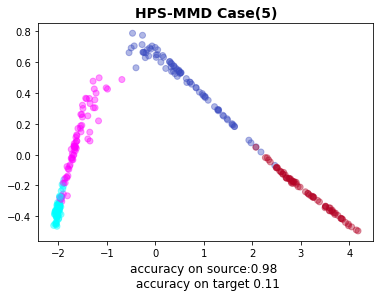

In [211]:
       
 #%%       
sess,pas,pat=train_and_evaluate(opt='adapt', verbose=True)
extract_and_plot_pca_feats(sess,pas,pat)    
 




Pretraining with no adaptation
loss: 0.7050915956497192, domain accuracy: 0.0, source accuracy: 0.375
loss: 0.30451926589012146, domain accuracy: 0.7733416557312012, source accuracy: 1.0
loss: 0.15271322429180145, domain accuracy: 1.8089818954467773, source accuracy: 1.0
loss: 0.15001541376113892, domain accuracy: 2.5467662811279297, source accuracy: 1.0
loss: 0.09623409062623978, domain accuracy: 3.838390827178955, source accuracy: 1.0
loss: 0.010266222059726715, domain accuracy: 2.1822426319122314, source accuracy: 1.0
loss: 0.06639625132083893, domain accuracy: 2.529644250869751, source accuracy: 1.0
loss: 0.017220379784703255, domain accuracy: 5.358419418334961, source accuracy: 1.0
loss: 0.0021249607671052217, domain accuracy: 3.0316507816314697, source accuracy: 1.0
loss: 0.017884299159049988, domain accuracy: 4.101000785827637, source accuracy: 1.0
loss: 0.0011217748979106545, domain accuracy: 1.8971432447433472, source accuracy: 1.0
loss: 0.004243077710270882, domain accuracy: 

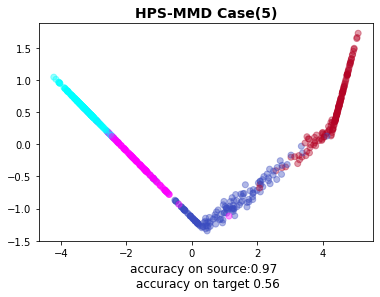

In [270]:
#%%
# pretrain source model with no adaptation

tf.reset_default_graph()
graph = tf.get_default_graph()

with graph.as_default():
    model = HPS('MMD',tf.nn.relu)

 #%%       
sess,pas,pat=train_and_evaluate(verbose=True)
extract_and_plot_pca_feats(sess,pas,pat)

In [271]:
#%%
feature=[]
for i in tf.trainable_variables(scope='source_feature_extractor'):
    feature.append(sess.run(i))
#%%
label_class=[]
for i in tf.trainable_variables(scope='label_predictor'):
    label_class.append(sess.run(i))

In [272]:
#%%
batch_size = 16
class SPS:
    """Simple soft parameter sharing (SPS) domain adaptation model."""
    def __init__(self,loss,activation):
        self.loss=loss
        self.build_model(activation)
        
    def build_model(self,activation=tf.nn.relu):
        self.X_s = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_s') # Input data
        self.X_t = tf.compat.v1.placeholder(tf.float32, [None, 2], name='X_t')
        self.Y_s = tf.compat.v1.placeholder(tf.int32, [None], name='Y_s')  # Class index
        self.Y_t = tf.compat.v1.placeholder(tf.int32, [None], name='Y_t')
        self.D_ind = tf.compat.v1.placeholder(tf.int32, [None], name='D_ind')  # Domain index
        self.train = tf.compat.v1.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
        self.l = tf.compat.v1.placeholder(tf.float32, [], name='l')        # Gradient reversal scaler

        y_s = tf.one_hot(self.Y_s, 2)
        y_t = tf.one_hot(self.Y_t, 2)

        D = tf.one_hot(self.D_ind, 2)

        # Feature extractor - single layer
        with tf.compat.v1.variable_scope('source_feature_extractor'):
            layer1=fc_layer(self.X_s,2,8, name="source_fc1",init_val=[feature[0],feature[1]])
            layer1=activation(layer1)
            F_s=fc_layer(layer1,8,16,name="source_fc2",init_val=[feature[2],feature[3]])
            self.F_s=activation(F_s)
        
        with tf.compat.v1.variable_scope('target_feature_extractor'):
            layer1_t=fc_layer(self.X_t,2,8, name="target_fc1",init_val=[feature[0],feature[1]])
            layer1_t=activation(layer1_t)
            F_t=fc_layer(layer1_t,8,16,name="target_fc2",init_val=[feature[2],feature[3]])
            self.F_t=activation(F_t)
        
        with tf.compat.v1.variable_scope('label_predictor'):
            # Label predictor - single layer
            target_features = lambda: self.F_t
            source_features = lambda: self.F_s
            classify_feats = tf.cond(self.train, source_features, target_features)

            target_labels = lambda:y_t
            source_labels = lambda:y_s
            self.classify_labels = tf.cond(self.train, source_labels, target_labels)
            dim=classify_feats.get_shape().as_list()[1]
          
            p_logit=fc_layer(classify_feats,dim,2,name='fc3',init_val=[label_class[0],label_class[1]],tr=False)
            p = tf.nn.softmax(p_logit)
            p_loss = tf.nn.softmax_cross_entropy_with_logits(logits=p_logit, labels=self.classify_labels )
        

        domain_merge=layers.concatenate([self.F_s,self.F_t],name='merged_features',axis=0)
        self.feature=domain_merge

        if self.loss=='MMD':
            with tf.variable_scope('MMD'):
                s_prop = fixprob(self.F_s)
                t_prop = fixprob(self.F_t)
               
                self.MMD_loss=tf.reduce_sum(mmd_loss(s_prop, t_prop,1))
                L2=sum(nonlinear_model(tf_var1,tf_var2,'lin%s'%(index)) for index, (tf_var1,tf_var2) in enumerate(zip(tf.trainable_variables( scope='source_feature_extractor')[0:4],tf.trainable_variables( scope='target_feature_extractor')[0:4])))

                self.pred_loss = tf.reduce_mean(p_loss, name='pred_loss')
                self.total_loss = self.pred_loss+0.5*self.MMD_loss+0.5*L2
                self.total_train_op = tf.train.AdamOptimizer().minimize(self.total_loss, name='mmd_train_op')
                

        elif self.loss=='DANN':

            with tf.variable_scope('domain_predictor'):
                feat = flip_gradient(self.feature,self.l)
        
                d=tf.compat.v1.layers.dense(feat,32,activation=activation)
                d=tf.compat.v1.layers.dense(d,16,activation=activation)
                d_logit=tf.compat.v1.layers.dense(d,2)
                d = tf.nn.softmax(d_logit)
                self.DC_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D))
                L2=sum(nonlinear_model(tf_var1,tf_var2,'lin%s'%(index)) for index, (tf_var1,tf_var2) in enumerate(zip(tf.trainable_variables( scope='source_feature_extractor')[0:4],tf.trainable_variables( scope='target_feature_extractor')[0:4])))

                self.pred_loss = tf.reduce_mean(p_loss, name='pred_loss')
                self.total_loss = self.pred_loss+self.DC_loss+0.5*L2
                self.total_train_op = tf.train.AdamOptimizer().minimize(self.total_loss, name='dann_train_op')
                
        
        # elif self.loss=='both':
        #     with tf.variable_scope('MMD'):
        #         s_prop = fixprob(self.F_s)
        #         t_prop = fixprob(self.F_t)
               
        #         self.MMD_loss=tf.reduce_sum(mmd_loss(s_prop, t_prop,1))

        #     with tf.variable_scope('domain_predictor'):
        #         feat = flip_gradient(self.feature,self.l)
        
        #         d=tf.compat.v1.layers.dense(feat,32,activation=activation)
        #         d=tf.compat.v1.layers.dense(d,16,activation=activation)
        #         d_logit=tf.compat.v1.layers.dense(d,2)
        #         d = tf.nn.softmax(d_logit)
        #         self.dann_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D))



        # Optimization


        # Evaluation
        self.p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.classify_labels, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')

        

def nonlinear_model(var1,var2,name):
    
    with tf.name_scope(name):
        
        var1=tf.reshape(var1,[-1])
        n=var1.get_shape().as_list()[0]
        var2=tf.reshape(var2,[-1])
       
        a= tf.Variable(tf.zeros(n), name="a")
        b=tf.Variable(tf.zeros(n), name="b")
        A=var1-var2-tf.keras.activations.tanh(a*var2+b)
       
        return tf.nn.l2_loss(A)       
 
#%%

sess.close()
tf.reset_default_graph()
graph = tf.get_default_graph()

with graph.as_default():
    model = SPS('MMD',tf.nn.relu)

       
def train_and_evaluate(grad_scale=None, num_batches=6000, verbose=True):
    # Create batch builders
    S_batches = batch_generator([X_train_s, y_train_s], batch_size // 2)
    T_batches = batch_generator([X_train_t, y_train_t], batch_size // 2)

    
    domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                                   np.tile([0., 1.], [batch_size // 2, 1])])
    
    # Get output tensors and train op
    
    p_acc = model.p_acc
    train_loss = model.pred_loss
    train_op = model.total_train_op
    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(num_batches):

        # If no grad_scale, use a schedule
        if grad_scale is None:
            p = float(i) / num_batches
            lp = 2. / (1. + np.exp(-10. * p)) - 1
        else:
            lp = grad_scale

        X0, y0 = next(S_batches)
        X1, y1 = next(T_batches)
        
        D_labels = np.hstack([np.zeros(batch_size // 2, dtype=np.int32),
                              np.ones(batch_size // 2, dtype=np.int32)])
        _, loss, pa = sess.run([train_op, train_loss, p_acc],
                                   feed_dict={model.X_s: X0, model.X_t: X1, model.Y_s: y0,model.Y_t: y1, model.D_ind: D_labels,
                                              model.train: True, model.l: lp})

        if verbose and i % 200 == 0:
            print('loss: {}, source accuracy: {}'.format(loss, pa))

            
    # Get final accuracies on whole dataset
    pas = sess.run(p_acc, feed_dict={model.X_s: X_test_s, model.X_t:X_test_t, model.Y_s: y_test_s,model.Y_t: y_test_t.shape, 
                            model.train: True, model.l: 1.0})
    pat = sess.run(p_acc, feed_dict={model.X_s: X_test_s, model.X_t: X_test_t, model.Y_s: y_test_s,model.Y_t: y_test_t,
                             model.train: False, model.l: 1.0})

    #print('Source domain: ', das)
    print('Source accuracy: ', pas)
    #print('Target domain: ', dat)
    print('Target accuracy: ', pat)
    return sess, pas,pat

#%%
  

In [273]:
def extract_and_plot_pca_feats(sess,source_acc,target_acc):
    
    emb_s = sess.run(model.F_s, feed_dict={model.X_s: X_test_s})
    emb_t = sess.run(model.F_t, feed_dict={model.X_t: X_test_t})
    emb_all = np.vstack([emb_s, emb_t])

    pca = PCA(n_components=2)
    pca_emb = pca.fit_transform(emb_all)

    num = pca_emb.shape[0] // 2
    plt.scatter(pca_emb[:num,0], pca_emb[:num,1], c=y_test_s, cmap='coolwarm', alpha=0.4,label='source')
    plt.scatter(pca_emb[num:,0], pca_emb[num:,1], c=y_test_t, cmap='cool', alpha=0.4,label='target')
    #plt.legend(loc='best')
    plt.title('Domain adaptation with soft parameter sharing',fontsize=14,fontweight='bold')
    plt.xlabel('accuracy on source:%.2f \n accuracy on target %.2f'%(source_acc,target_acc) ,fontsize=12)

loss: 0.0012384732253849506, source accuracy: 1.0
loss: 0.7585972547531128, source accuracy: 0.625
loss: 0.4748573303222656, source accuracy: 0.75
loss: 0.00849046092480421, source accuracy: 1.0
loss: 0.003634174121543765, source accuracy: 1.0
loss: 0.008122704923152924, source accuracy: 1.0
loss: 0.005817764904350042, source accuracy: 1.0
loss: 0.0025680263061076403, source accuracy: 1.0
loss: 0.0007056408794596791, source accuracy: 1.0
loss: 0.020651066675782204, source accuracy: 1.0
loss: 0.001507564214989543, source accuracy: 1.0
loss: 0.01763138920068741, source accuracy: 1.0
loss: 0.0912773460149765, source accuracy: 0.875
loss: 0.8367539644241333, source accuracy: 0.875
loss: 0.0013438661117106676, source accuracy: 1.0
loss: 0.0015538940206170082, source accuracy: 1.0
loss: 0.00231743510812521, source accuracy: 1.0
loss: 0.0008586283074691892, source accuracy: 1.0
loss: 0.03627900779247284, source accuracy: 1.0
loss: 0.00211442937143147, source accuracy: 1.0
loss: 0.010717771947

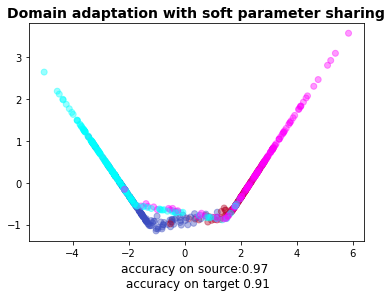

In [274]:
sess,pas,pat=train_and_evaluate( verbose=True)
extract_and_plot_pca_feats(sess,pas,pat)  